# Fit atmospheric parameters-  no filter date 2023/01/18 PSF2DFFM


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : February 11th 2023
- last update : February 11th 2023


# Import

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline
import pickle


In [2]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [4]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits',
 'comptable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits',
 'thermtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [5]:
import time
from datetime import datetime,date
from astropy.time import Time
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [6]:
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import fftpack

In [7]:
# import libradtran
sys.path.append('../../../simulation/atmsim/libradtran')
import libsimulateVisible

libradtranpath= /Users/dagoret/MacOSX/External/libRadtran2/


In [8]:
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES

class Line:
    """Class modeling the emission or absorption lines."""

    def __init__(self, wavelength, label, atmospheric=False, emission=False, label_pos=[0.007, 0.02],
                 width_bounds=[0.5, 6], use_for_calibration=False):
        """Class modeling the emission or absorption lines. lines attributes contains main spectral lines
        sorted in wavelength.

        Parameters
        ----------
        wavelength: float
            Wavelength of the spectral line in nm
        label: str

        atmospheric: bool
            Set True if the spectral line is atmospheric (default: False)
        emission: bool
            Set True if the spectral line has to be detected in emission. Can't be true if the line is atmospheric.
            (default: False)
        label_pos: [float, float]
            Position of the label in the plot with respect to the vertical lin (default: [0.007,0.02])
        width_bounds: [float, float]
            Minimum and maximum width (in nm) of the line for fitting procedures (default: [1,7])
        use_for_calibration: bool
            Use this line for the dispersion relation calibration, bright line recommended (default: False)

        Examples
        --------
        >>> l = Line(550, label='test', atmospheric=True, emission=True)
        >>> print(l.wavelength)
        550
        >>> print(l.label)
        test
        >>> print(l.atmospheric)
        True
        >>> print(l.emission)
        False
        """
        self.wavelength = wavelength  # in nm
        self.label = label
        self.label_pos = label_pos
        self.atmospheric = atmospheric
        self.emission = emission
        if self.atmospheric:
            self.emission = False
        self.width_bounds = width_bounds
        self.fitted = False
        self.use_for_calibration = use_for_calibration
        self.high_snr = False
        self.fit_lambdas = None
        self.fit_gauss = None
        self.fit_bgd = None
        self.fit_snr = None
        self.fit_fwhm = None
        self.fit_popt = None
        self.fit_pcov = None
        self.fit_popt_gaussian = None
        self.fit_pcov_gaussian = None
        self.fit_chisq = None
        self.fit_eqwidth_mod = None
        self.fit_eqwidth_data = None
        #self.fit_bgd_npar = parameters.CALIB_BGD_NPARAMS
        self.fit_bgd_npar = None


In [9]:
HALPHA = Line(656.3, atmospheric=False, label='$H\\alpha$', label_pos=[-0.01, 0.02], use_for_calibration=True)
HBETA = Line(486.3, atmospheric=False, label='$H\\beta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA = Line(434.0, atmospheric=False, label='$H\\gamma$', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA = Line(410.2, atmospheric=False, label='$H\\delta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON = Line(397.0, atmospheric=False, label='$H\\epsilon$', label_pos=[0.001, 0.02], use_for_calibration=True)

HZETA = Line(388.9064, atmospheric=False, label='$H\\zeta$', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA = Line(383.5397, atmospheric=False, label='$H\\eta$', label_pos=[0.001, 0.02], use_for_calibration=False)

HBETA2 = Line(486.3*2, atmospheric=False, label='$H\\beta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA2 = Line(434.0*2, atmospheric=False, label='$H\\gamma$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA2 = Line(410.2*2, atmospheric=False, label='$H\\delta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON2 = Line(397.0*2, atmospheric=False, label='$H\\epsilon$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HZETA2 = Line(388.9064*2, atmospheric=False, label='$H\\zeta$2', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA2 = Line(383.5397*2, atmospheric=False, label='$H\\eta$2', label_pos=[0.001, 0.02], use_for_calibration=False)

O2_1 = Line(760.3, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3
O2_2 = Line(763.1, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3

O2B = Line(687.472, atmospheric=True, label=r'$O_2(B)$',  # 687.472 is a weighted average of the O2B line simulated by Libradtran
           label_pos=[0.001, 0.02], use_for_calibration=True)  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Y = Line(898.765, atmospheric=True, label=r'$O_2(Y)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Z = Line(822.696, atmospheric=True, label=r'$O_2(Z)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
# H2O = Line( 960,atmospheric=True,label='$H_2 O$',label_pos=[0.007,0.02],width_bounds=(1,50))  #
H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
              width_bounds=[5, 30])  # libradtran paper fig.3, broad line
ATMOSPHERIC_LINES = [O2_1, O2_2, O2B, O2Y, O2Z, H2O_1]


H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

#my_calib_lines_etador = Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON,HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,O2_1,O2_2],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
#hydrogen_lines_order1 =  Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON])
#hydrogen_lines_order2 =  Lines([HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,HETA2])
#oxygen_lines_order1 = Lines([O2_1,O2_2])

In [10]:
#ax.plot([x_O2_1,x_O2_1],[72,100],'b-',lw=3)
#ax.annotate(O2_1.label, xy=(x_O2_1, 80), color='b',fontsize=20,fontweight='bold')

In [11]:
os.getenv("PYSYN_CDBS")

'/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs'

In [12]:
path_calspec = os.path.join(os.getenv("PYSYN_CDBS"),"calspec")
dict_sedfilename = {'HD38666': "mucol_stis_005.fits", 
            'HD185975': "hd185975_stis_003.fits",
            'HD074000': "hd074000_stis_003.fits",
            'HD60753' : "hd60753_stis_003.fits",
            'HD111980': "hd111980_stis_003.fits"}         

# Functions

- filtering here

https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

In [13]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

In [14]:
def atmpatt_Dataf_to_np(df):
    """
    
    atmpatt_Dataf_to_np : convert pandas dtaframe on abs pattern into numpy array
    
    """
    o2_cols = []
    for tabcol in df.columns:
        if 'o2_' in tabcol and 'no2_' not in tabcol:
            o2_cols.append(tabcol)
            
    no2_cols = []
    for tabcol in df.columns:
        if 'no2_' in tabcol:
            no2_cols.append(tabcol)
            
            
    h2o_cols = []
    for tabcol in df.columns:
        if 'h2o_' in tabcol:
            h2o_cols.append(tabcol)
            
            
    o3_cols = []
    for tabcol in df.columns:
        if 'o3_' in  tabcol:
            o3_cols.append(tabcol)
            
            
    data_wl = df["wl"].to_numpy()
    data_o2 = df[o2_cols].to_numpy()
    data_o3 = df[o3_cols].to_numpy()
    data_h2o = df[h2o_cols].to_numpy()
    data_no2 = df[no2_cols].to_numpy()
    
    
    return data_wl, data_o2, data_o3, data_h2o, data_no2
    
    

In [15]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [16]:
def GetSpectra(dict_spectra,factor=1.):
    """
    GetSpectra(dict_spectra)
    
    input:
      - dict_spectra : dictionnary of input spectra
      
      
      {'number': 238.0, 'object': 'mu. Col', 'dateobs': '2022-03-18T00:51:22.049', 'refhour': 0.0, 'airmass': 1.11557476948966, 'pressure': 743.45, 'temperature': 8.9, 
      'humidity': 48.0, 'targetx_pix': 312.7442668572934, 'targety_pix': 1738.0006619324693, 'rotangle': 0.1753951396614214, 'd2ccd': 181.0974436798836, 
      'all_lambdas': array([ 302.20970512,  302.91544585,  303.62117594, ..., 1108.67461764,
       1109.35162338, 1110.02859124]), 'all_fluxes': array([1.04110833e-13, 9.83856109e-14, 8.99209206e-14, ...,
       5.34113538e-13, 5.36905940e-13, 5.53127394e-13]), 'all_fluxes_err': array([3.51303583e-15, 3.10100695e-15, 2.58677333e-15, ...,
       3.34568263e-15, 4.01784054e-15, 4.54242555e-15]), 'all_lambdas_order2': array([ 302.24857475,  302.9543149 ,  303.66004442, ..., 1108.71192607,
       1109.38892974, 1110.06589555]), 'all_fluxes_order2': array([420.23653349, 386.95227531, 344.90384603, ...,  60.47440612,
        60.74615545,  62.53491353]), 'all_fluxes_err_order2': array([14.15542468, 12.17674916,  9.90751987, ...,  0.37846535,
        0.45415764,  0.51307916])}
      
    
    return
      - list of dataframes
    """
    
    #correction_area = 1.06/1.13
    correction_area = 1
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0
    sorted_dict_spectra_items = sorted(dict_spectra.items())
    for key, value in sorted_dict_spectra_items:
        
        df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']]
         
        df = pd.DataFrame()
        df["all_lambdas"] = value["all_lambdas"]
        df["all_fluxes"] = value["all_fluxes"]/ correction_area*factor 
        df["all_fluxes_err"] = value["all_fluxes_err"]*factor
        
        if 'all_lambdas_order2' in value.keys():
            df["all_lambdas_order2"] = value["all_lambdas_order2"]
            df["all_fluxes_order2"] = value["all_fluxes_order2"]/ correction_area*factor 
            df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]*factor
            
        
        all_df.append(df)
        
        
        idx+=1
        
    return df_info , all_df

In [17]:
def GetSpectraFiltered(dict_spectra,list_of_bad_spectra,factor = 1.):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - dict_spectra
      - ist_of_bad_spectra
    
    return
      - filtered infos, filtered spectra
    """
    
    # factor to correct fluxes (over estimated collection surface)
    #correction_area = 1.06/1.13
    correction_area = 1
    
    
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   
        

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0       # counter on input spectra
    idx_out = 0 # counter on save spectra
    #for key, value in dict_spectra.items():
    sorted_dict_spectra_items = sorted(dict_spectra.items())
    for key, value in sorted_dict_spectra_items:
        
        
        if int(value["number"]) not in list_of_bad_spectra:
        
            
            df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']] 
        
            df = pd.DataFrame()
            df["all_lambdas"] = value["all_lambdas"]
            df["all_fluxes"] = value["all_fluxes"]/correction_area*factor
            df["all_fluxes_err"] = value["all_fluxes_err"]*factor
        
            if 'all_lambdas_order2' in value.keys():
                df["all_lambdas_order2"] = value["all_lambdas_order2"]
                df["all_fluxes_order2"] = value["all_fluxes_order2"]/correction_area*factor
                df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]*factor
               
            all_df.append(df)
            idx_out+=1  # increase count on saved spectra
            
        else:
            num = int(value["number"])
            msg = f"Remove spectrum {idx} for exposure {num}"
            print(msg)
            
        idx+=1
            

        
    return df_info,all_df

In [18]:
def FindPairOfExposures(df):
    """
    
    Find pair of exposures at similar airmass, one before culmination, the other one after the exposure
    
    - input : pandas dataframe with infos
    - output : pandas dataframe with pairs
    
    """
    
    
 
    # the culmination  
    idx_zmin = df["airmass"].idxmin()
    
    # split this dataframe into 2
    
    # df before culmination
    df1 = df.iloc[0:idx_zmin]
    
    # df after culmination
    df2 = df.iloc[idx_zmin+1:-1]
    
    #print(df1)
    
    #print(df2)
    
    # loop on exposure before culmination
    #for irow in range(0,idx_zmin):
        # print(irow,df1.iloc[irow][["number","airmass"]])
        
    dist = np.abs(df1["airmass"][np.newaxis, :] - df2["airmass"][:, np.newaxis])
    #print(dist)
    closest_idx = np.argmin(dist, axis=0)
    closest_id = df2.iloc[closest_idx]["number"].to_numpy()
    df_output = pd.DataFrame({"idx1": np.arange(0,idx_zmin), 
                              "idx2": closest_idx+idx_zmin+1,
                              "num1":df1["number"],
                              "num2":closest_id,
                              "z1":df1["airmass"].values,
                              "z2":df2.iloc[closest_idx]["airmass"].to_numpy()})

    df_output["zdiff"] =  df_output["z2"]-df_output["z1"]
    df_output["dtime"] = df2.iloc[closest_idx]["refhour"].to_numpy()- df1["refhour"] 
    return df_output
    

In [19]:
def FindPairOfExposuresFromFirst(df):
    """
    
    - input : pandas dataframe with infos
    - output : pandas dataframe with pairs
    
    """ 
 

    idx_start = 0
    
    # split this dataframe into 2
    
    # df before culmination
    df1 = df.iloc[:idx_start+1]
    
    # df after culmination
    df2 = df.iloc[idx_start+1:]
    N2=len(df2)
    

    df1_new = df1.copy(deep=True)
    df1_new = pd.concat([df1]*(N2),axis=0)
 
    df1=df1_new
    N1=len(df1)
   
    df_output = pd.DataFrame({"idx1": np.full(N1,0), 
                              "idx2": np.arange(1,N2+1),
                              "num1":df1["number"].values,
                              "num2":df2["number"].values,
                              "z1":df1["airmass"].values,
                              "z2":df2["airmass"].values,
                              "t1":df1["refhour"].values,
                              "t2":df2["refhour"].values})

    df_output["zdiff"] =  df_output["z2"]-df_output["z1"]
    df_output["dtime"] = df_output["t2"]-df_output["t1"]
    return df1,df2,df_output
    

# Constants

# Initialisation

In [20]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [21]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2023-02-11 20:41:51,872 MacBook-Pro-de-admin.local __main__[11674] INFO LA time:11:41:51
2023-02-11 20:41:51,875 MacBook-Pro-de-admin.local __main__[11674] INFO NY time:14:41:51
2023-02-11 20:41:51,877 MacBook-Pro-de-admin.local __main__[11674] INFO London time:19:41:51
2023-02-11 20:41:51,879 MacBook-Pro-de-admin.local __main__[11674] INFO Paris time:20:41:51
2023-02-11 20:41:51,879 MacBook-Pro-de-admin.local __main__[11674] INFO ************************ START *********************


In [22]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [23]:
DATE = 20230118
FILTERTYPE = "empty~holo_003"
spectractormode = "psf2dffm"
ext = "rebin2"   # run BPS by removing ACQ

In [24]:
# config file
# --------------
#configfile = "config/default.ini"
if ext == None or ext == "":
    configfile = f"config/{DATE}/{FILTERTYPE}/confprog_run-auxtel-{DATE}-{FILTERTYPE}_{spectractormode}.ini"
else:
    configfile = f"config/{DATE}/{FILTERTYPE}/confprog_run-auxtel-{DATE}-{FILTERTYPE}_{spectractormode}_{ext}.ini"
    
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2023-02-11 20:41:51,904 MacBook-Pro-de-admin.local __main__[11674] INFO Configuration file : config/20230118/empty~holo_003/confprog_run-auxtel-20230118-empty~holo_003_psf2dffm_rebin2.ini


In [25]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2023-02-11 20:41:51,911 MacBook-Pro-de-admin.local __main__[11674] INFO 1) Configuration


In [26]:
config_section = config.sections()

In [27]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [28]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    
    SITE          = config['GENERAL']['SITE']
    DATE          = config['GENERAL']['DATE']
    
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    filterdisperser =  config['GENERAL']['filterdisperser']
    
    
    
    filename_auxtelthroughput = config['GENERAL']['filename_auxtelthroughput']
   
    spectractormode = config['GENERAL']['spectractormode']
   
    normalisationfactor = float(config['GENERAL']['normalisationfactor'])
    
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    
    
    MAGLIMMIN     = float(config['GENERAL']['MAGLIMMIN'])
    MAGLIMMAX     = float(config['GENERAL']['MAGLIMMAX'])
    FLUXLIMMIN    = float(config['GENERAL']['FLUXLIMMIN'])
    FLUXLIMMAX    = float(config['GENERAL']['FLUXLIMMAX'])    
    
    NPOINTSVIEW       =    int(config['GENERAL']['NPOINTSVIEW']) 
    NPOINTSSAVE       =    int(config['GENERAL']['NPOINTSSAVE']) 
    inputfile_linearfit =  config['GENERAL']['outputfile_linearfit']
    inputfile_gp        =  config['GENERAL']['outputfile_gp']
    
    BADEXPOS = config['GENERAL']['BADEXPOS']
    

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)

In [29]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

In [30]:
list_of_badnums1 = [int(nn)  for nn in BADEXPOS.split()]
list_of_badnums1

[208,
 299,
 312,
 313,
 322,
 375,
 420,
 463,
 464,
 482,
 563,
 564,
 618,
 626,
 627,
 707,
 375,
 226,
 227,
 264,
 273,
 274,
 300,
 346,
 347,
 419,
 501]

In [31]:
WL= np.arange(WLMINSEL,WLMAXSEL)

# input files

## Get Calspec SED

- Notice we use a relative normalisation factor

In [32]:
path_calspec

'/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec'

In [33]:
dict_f_sed = {}
dict_name_sed = {}

In [34]:
for targetid, sedfilename in dict_sedfilename.items():
    print(targetid, '->', sedfilename)
    s0=S.FileSpectrum(os.path.join(path_calspec,sedfilename))
    
    the_targetname = s0.fheader['TARGETID']
    
    sed_w=s0.wave/10
    sed_f=s0.flux*10*normalisationfactor
    sed_idx=np.where(np.logical_and(sed_w> WLMINSEL ,sed_w< WLMAXSEL))[0]
    sed_w=sed_w[sed_idx]
    sed_f=sed_f[sed_idx]
    
    # interpolation function
    f_sed = interpolate.interp1d(sed_w,sed_f,bounds_error=False,fill_value="extrapolate")
    
    dict_name_sed[targetid] = the_targetname
    dict_f_sed[targetid] = f_sed 


HD38666 -> mucol_stis_005.fits
HD185975 -> hd185975_stis_003.fits
Warning, 16 of 3740 bins contained negative fluxes; they have been set to zero.
HD074000 -> hd074000_stis_003.fits
HD60753 -> hd60753_stis_003.fits
HD111980 -> hd111980_stis_003.fits


In [35]:
dict_name_sed

{'HD38666': 'MUCOL',
 'HD185975': 'HD185975',
 'HD074000': 'HD074000',
 'HD60753': 'HD60753',
 'HD111980': 'HD111980'}

In [36]:
sed_m=-2.5*np.log10(sed_f)

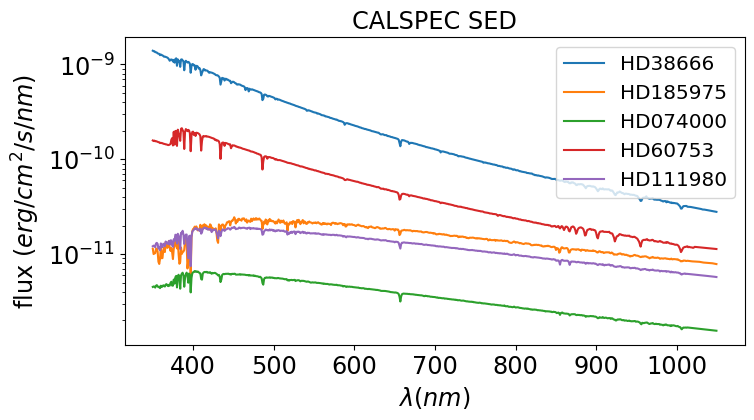

In [37]:
fig=plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)

for targetid, f_sed  in dict_f_sed.items():

    sed = f_sed(WL)
    sed_m=-2.5*np.log10(sed)
    
    label= f"{targetid}"
    ax.plot(WL,sed,label=label)
    
ax.set_xlabel("$\\lambda (nm)$")
ax.set_ylabel("flux $(erg/cm^2/s/nm)$")
ax.set_title("CALSPEC SED")
ax.set_yscale('log')
ax.legend(loc='upper right')
#ax2=ax.twinx()
#ax2.plot(sed_w,sed_m,'r-')
#ax2.set_ylabel("mag")

# Throughputs

## Auxtel throughput and  telescope throughput

In [38]:
array = np.loadtxt(filename_auxtelthroughput)
dft = pd.DataFrame(data=array,columns=["lambda","throughput"])

In [39]:
#dft = pd.read_excel(filename_auxtelthroughput,header=1,index_col=0)
dft.reset_index(inplace=True)
dft['index'] = dft.reset_index().index
dft.set_index('index')
dft.rename(columns={'lambda':'lambdas'},inplace = True)

Text(0.5, 1.0, 'auxtel throughput')

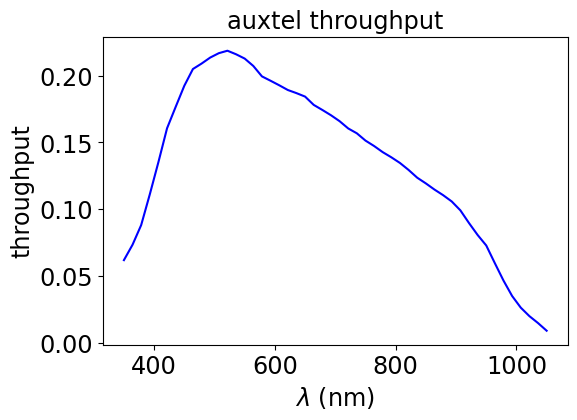

In [40]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.plot(dft.lambdas,dft.throughput,"b-")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("throughput")
ax.set_title("auxtel throughput")

In [41]:
# interpolation function
f_thr = interpolate.interp1d(dft.lambdas,dft.throughput,bounds_error=False,fill_value="extrapolate")

## spectrum data

In [42]:
fullfilename=os.path.join(inputdir,inputfile)

In [43]:
!ls data

20230117
20230118
20230119
20230131
20230201
20230202
absorption_pattern.csv
run-auxtel-holo-20230117-empty~holo4_003-PSF2DFFM_REBIN1-oga.pickle
run-auxtel-holo-20230117-empty~holo4_003-PSF2DFFM_REBIN2.pickle
run-auxtel-holo-20230117-empty~holo4_003-PSF2DFFM_REBIN2_b.pickle
run-auxtel-holo-20230119-empty~holo4_003-PSF2DFFM_REBIN2.pickle
run-auxtel-holo-20230119-empty~holo4_003-PSF2DFFM_REBIN2_b.pickle


In [44]:
with open(fullfilename, 'rb') as f:
    summary_content = pickle.load(f)

In [45]:
NBSPECTRA=len(summary_content)

In [46]:
msg=f" Number of selected files is {NBSPECTRA}"
logger.info(msg)

2023-02-11 20:41:53,317 MacBook-Pro-de-admin.local __main__[11674] INFO  Number of selected files is 77


In [47]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

### Read all files

In [48]:
normalisationfactor

1.0

In [49]:
infos, all_spectra = GetSpectra(summary_content,factor = normalisationfactor)

In [50]:
N=len(infos)

In [51]:
NX=4
NY=N/NX

In [52]:
if NY != int(NY):
    NY= int(NY)+1
else:
    NY=int(NY)

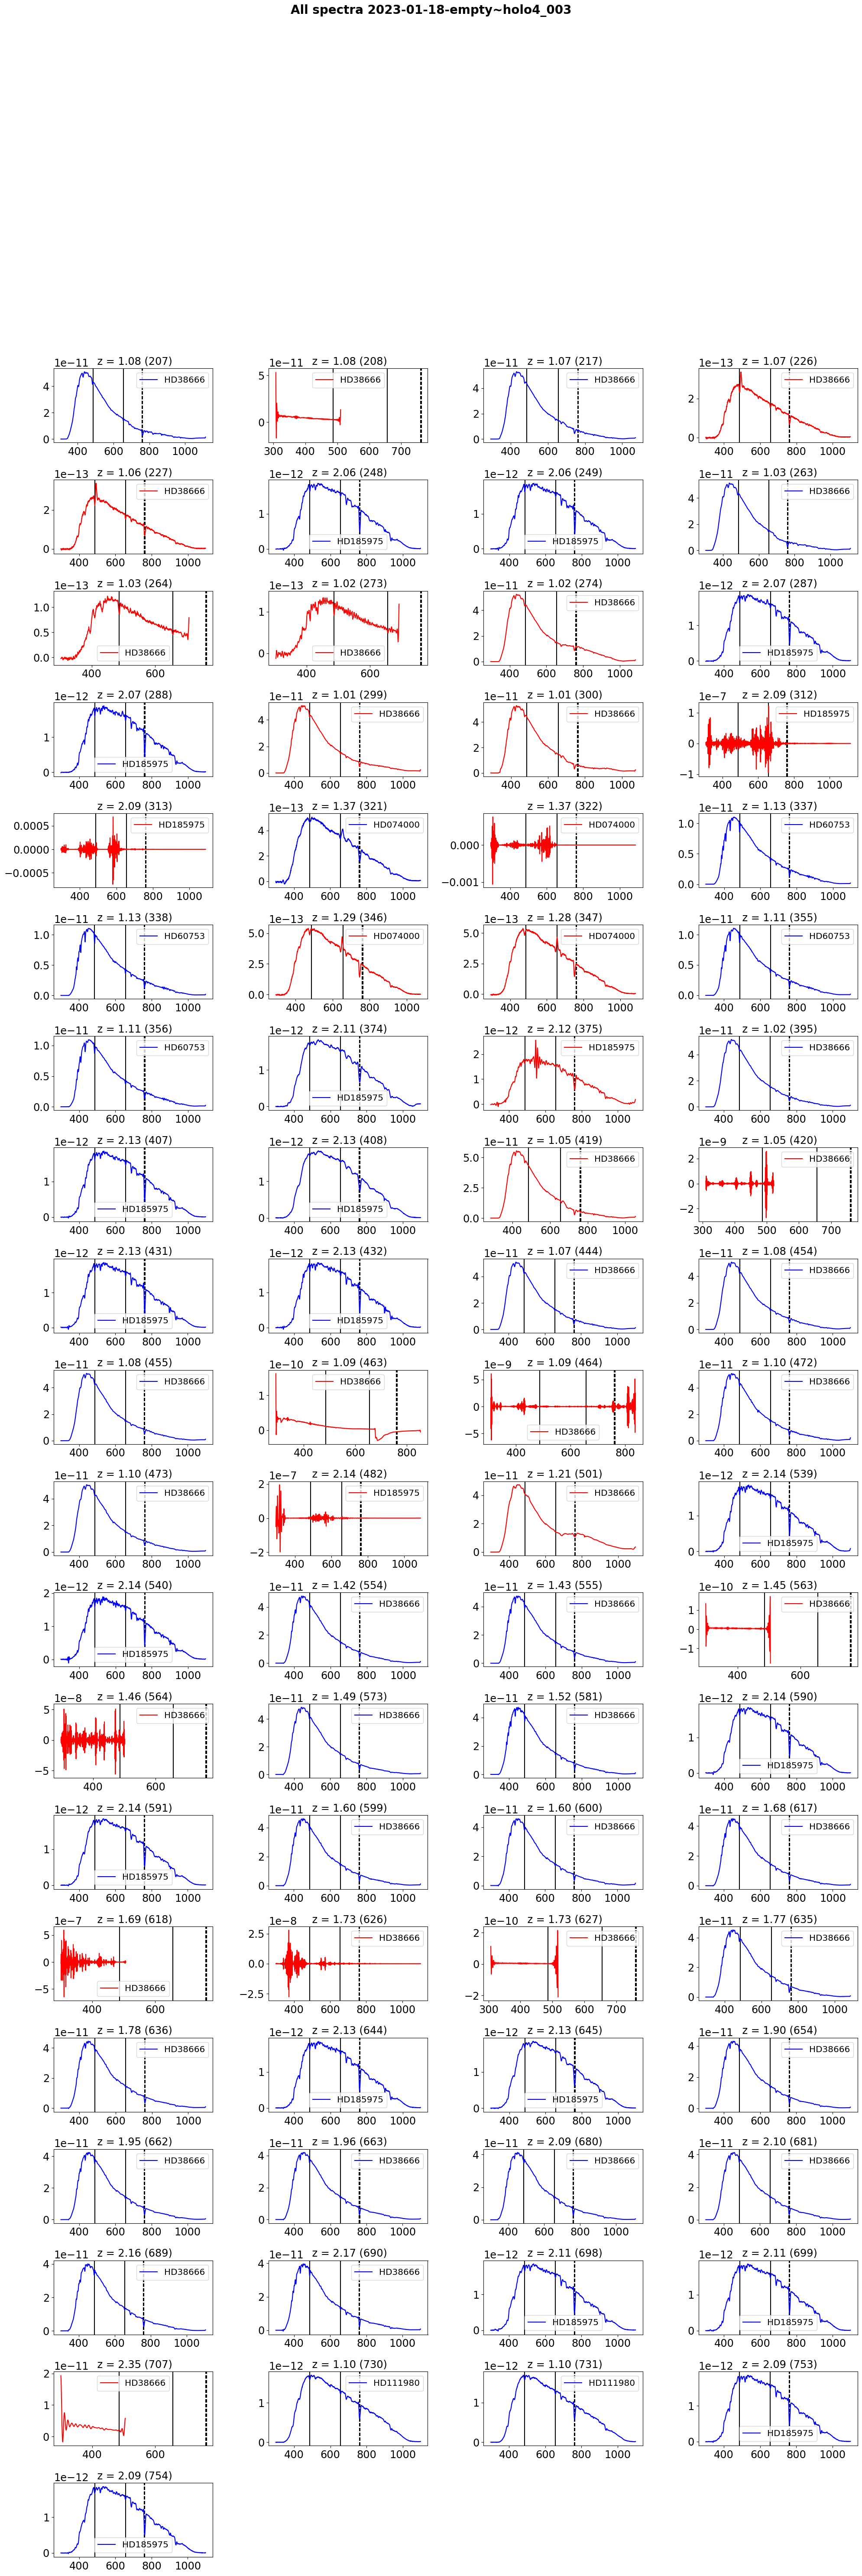

In [53]:
fig = plt.figure(figsize=(20,NY*3))

ny=0
nx=0

for idx in range(N):
    iy = idx//NX
    ix = (idx-iy*NX)
    
    ax=fig.add_subplot(NY,NX,idx+1)
    
    
    
    the_df=all_spectra[idx]
    
    airmassvalue = infos.iloc[idx]["airmass"]
    num = infos.iloc[idx]["number"]
    label_airmass = f" z = {airmassvalue:.2f} ({num})"
    the_target = infos.iloc[idx]["object"]
    
    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    if num in list_of_badnums1:
        thecolor="r"
    else:
        thecolor="b"
    
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '-', color=thecolor,capsize = 0.01, ecolor="k", elinewidth = .01,label=the_target)
    ax.set_title(label_airmass)
    
    ax.axvline(HBETA.wavelength,linestyle="-",color="k")
    ax.axvline(HALPHA.wavelength,linestyle="-",color="k")
    
    # O2 line
    ax.axvline(O2_1.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,linestyle="--",color="k")
    #ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.legend()
    
the_title = f"All spectra {DATE}-{filterdisperser}"

plt.suptitle(the_title,size=20,fontweight='bold',y=0.99)    
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig_filename = f"fig_01-{DATE}-{filterdisperser}.pdf"
plt.savefig(fig_filename)
plt.show()

# Remove bad Spectra

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_11674/3308870561.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')


Text(0.5, 1.0, 'nb of spectra per target before spectra selection ')

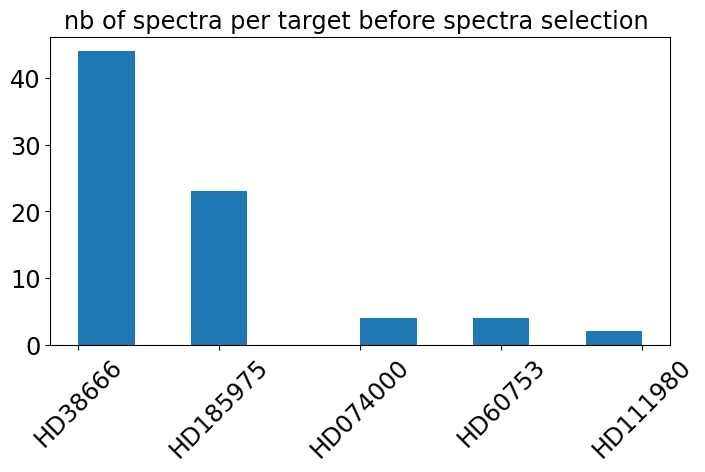

In [54]:
fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.hist(infos.object);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
ax.set_title("nb of spectra per target before spectra selection ")

Text(0.5, 0.98, 'Variables to apply selection')

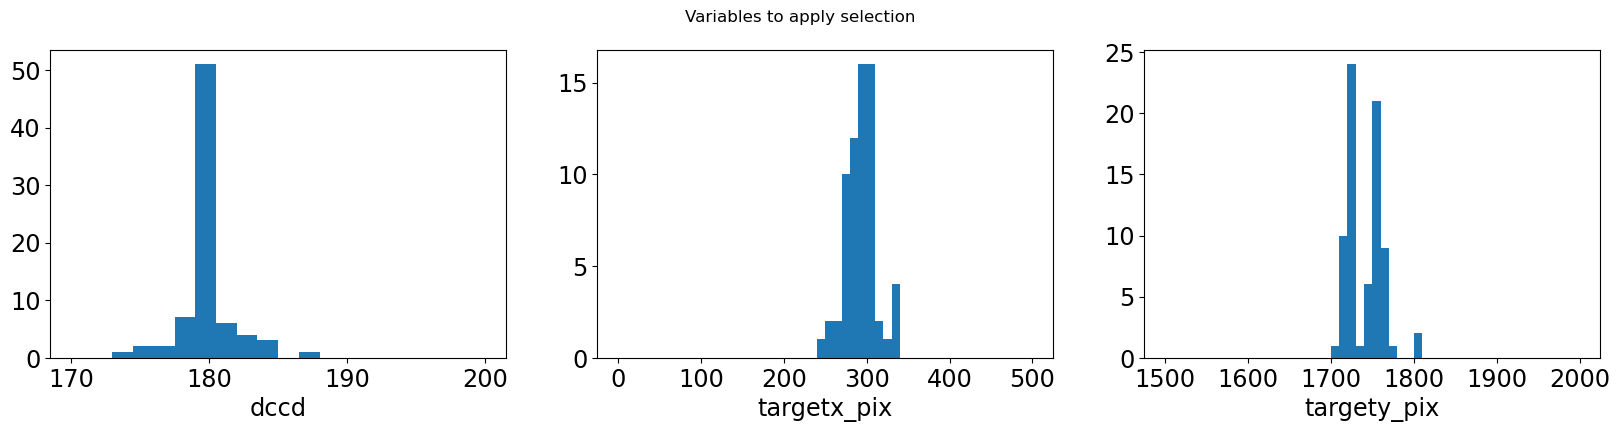

In [55]:
fig = plt.figure(figsize=(20,4))
ax=fig.add_subplot(1,3,1)
ax.hist(infos.d2ccd,bins=20,range=(170,200));
ax.set_xlabel("dccd")
ax=fig.add_subplot(1,3,2)
ax.hist(infos.targetx_pix,bins=50,range=(0,500));
ax.set_xlabel("targetx_pix")
ax=fig.add_subplot(1,3,3)
ax.hist(infos.targety_pix,bins=50,range=(1500,2000));
ax.set_xlabel("targety_pix")
plt.suptitle("Variables to apply selection")

## Define selection cut

In [56]:
#selection_cut = ((infos.d2ccd > 178) & (infos.d2ccd < 182)) & (infos.object == target)
selection_cut = ((infos.d2ccd > 178) & (infos.d2ccd < 182))
bad_cut = ~selection_cut

In [57]:
list_of_badnums2 = infos[bad_cut]["number"].values
list_of_badnums2 

array([207, 208, 217, 274, 300, 312, 346, 347, 419, 420, 463, 464, 627,
       635])

# Union of badnums

In [58]:
list_of_badnums = np.union1d(list_of_badnums1,list_of_badnums2)
list_of_badnums=np.unique(list_of_badnums)

# Filtered spectra : remove bad spectra

In [59]:
list_of_badnums

array([207, 208, 217, 226, 227, 264, 273, 274, 299, 300, 312, 313, 322,
       346, 347, 375, 419, 420, 463, 464, 482, 501, 563, 564, 618, 626,
       627, 635, 707])

In [60]:
infos, all_spectra = GetSpectraFiltered(summary_content,list_of_bad_spectra=list_of_badnums,factor = normalisationfactor)

Remove spectrum 0 for exposure 207
Remove spectrum 1 for exposure 208
Remove spectrum 2 for exposure 217
Remove spectrum 3 for exposure 226
Remove spectrum 4 for exposure 227
Remove spectrum 8 for exposure 264
Remove spectrum 9 for exposure 273
Remove spectrum 10 for exposure 274
Remove spectrum 13 for exposure 299
Remove spectrum 14 for exposure 300
Remove spectrum 15 for exposure 312
Remove spectrum 16 for exposure 313
Remove spectrum 18 for exposure 322
Remove spectrum 21 for exposure 346
Remove spectrum 22 for exposure 347
Remove spectrum 26 for exposure 375
Remove spectrum 30 for exposure 419
Remove spectrum 31 for exposure 420
Remove spectrum 37 for exposure 463
Remove spectrum 38 for exposure 464
Remove spectrum 41 for exposure 482
Remove spectrum 42 for exposure 501
Remove spectrum 47 for exposure 563
Remove spectrum 48 for exposure 564
Remove spectrum 56 for exposure 618
Remove spectrum 57 for exposure 626
Remove spectrum 58 for exposure 627
Remove spectrum 59 for exposure 635

In [61]:
print("Number of spectra : ",len(all_spectra))

Number of spectra :  48


In [62]:
infos.reset_index(drop=True, inplace=True)

In [63]:
infos

,number,object,dateobs,refhour,airmass,pressure,temperature,humidity,filename,targetx_pix,targety_pix,rotangle,d2ccd
0,248,HD185975,2023-01-19T01:24:39.497501381Z,-0.220871,2.056276,0,0,0,2023011800248,287.314071,1762.905011,0.448171,180.100348
1,249,HD185975,2023-01-19T01:25:22.309003658Z,-0.208979,2.056715,0,0,0,2023011800249,289.847805,1766.093118,0.461313,179.964787
2,263,HD38666,2023-01-19T01:37:11.815992158Z,-0.011894,1.026161,0,0,0,2023011800263,302.843989,1754.574004,0.232688,178.282896
3,287,HD185975,2023-01-19T01:55:10.535505895Z,0.287750,2.074152,0,0,0,2023011800287,304.775198,1762.266242,0.489120,180.056654
4,288,HD185975,2023-01-19T01:55:53.539995972Z,0.299696,2.074566,0,0,0,2023011800288,306.325962,1762.668304,0.488203,180.115528
5,321,HD074000,2023-01-19T02:31:44.296009374Z,0.897128,1.373299,0,0,0,2023011800321,287.166053,1725.659755,0.283018,180.255334
6,337,HD60753,2023-01-19T02:45:32.810994662Z,1.127271,1.126568,0,0,0,2023011800337,297.828957,1721.417588,0.247011,180.250522
7,338,HD60753,2023-01-19T02:46:15.633005964Z,1.139166,1.125665,0,0,0,2023011800338,298.010088,1723.023339,0.245426,180.287572
8,355,HD60753,2023-01-19T02:57:57.100500175Z,1.334018,1.111968,0,0,0,2023011800355,313.977479,1722.634260,0.238427,180.325644
9,356,HD60753,2023-01-19T02:58:39.956998603Z,1.345923,1.111194,0,0,0,2023011800356,314.927332,1723.338651,0.240743,180.340824


/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_11674/3614807563.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')


Text(0.5, 1.0, 'nb of spectra per target after spectra selection ')

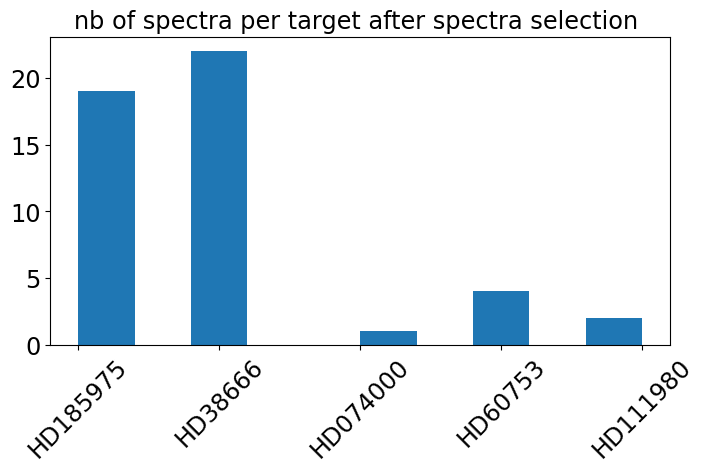

In [64]:
fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
ax.hist(infos.object);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')
ax.set_title("nb of spectra per target after spectra selection ")

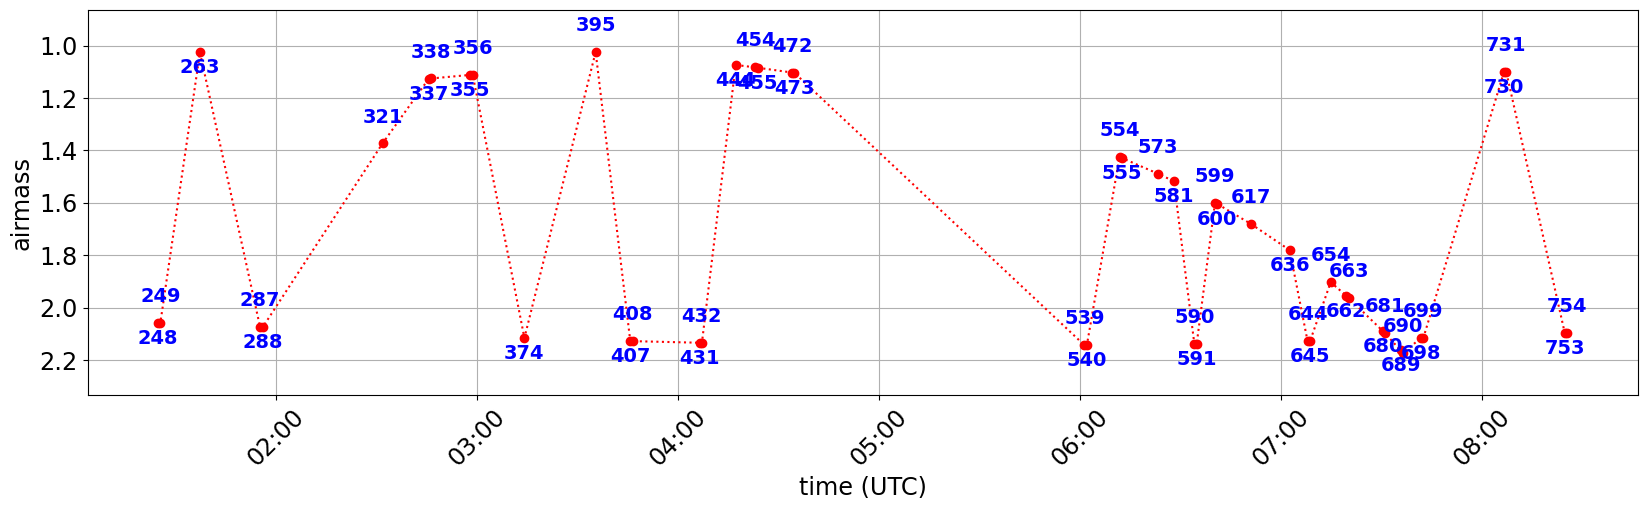

In [65]:
all_datetime = [ Time(str_time).to_datetime() for str_time in infos['dateobs'] ]
numbers = infos['number'].values
airmasses = infos['airmass'].values
N= len(numbers)

myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)


# Create rectangle x coordinates
startTime = all_datetime[0]
endTime =  datetime(2023, 1, 31, 0, 0, 0, 0),

# convert to matplotlib date representation
start = mdates.date2num(startTime)
end = mdates.date2num(endTime)
width = end - start



fig=plt.figure(figsize=(20,5))
ax=fig.add_subplot(111)
#ax.plot(all_datetime,grey_attenuation,'bo:')
#ax.grid()
#plt.gcf().autofmt_xdate()
#ax.xaxis.set_major_formatter(myFmt)
#ax.xaxis.set_tick_params(rotation=45)
#ax.set_xlabel("time (UTC)")
#ax.set_title(f"Grey attenuation : {DATE} ({filterdisperser}, {target})")
#ax.set_ylabel("attenuation")
#ax2 = ax.twinx()

y_shift= 0.08

ax2=ax
ax2.plot(all_datetime,airmasses,'r:o')
ax2.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_tick_params(rotation=45)
ax2.set_xlabel("time (UTC)")
ax2.set_ylabel("airmass")
ax2.set_ylim(airmasses.min()-2*y_shift,airmasses.max()+2*y_shift)
# Plot rectangle
#rect = plt.Rectangle((start, airmasses.min()-2*y_shift), width, airmasses.max()+ 2*y_shift, color='grey',alpha=0.3)
#ax2.add_patch(rect)   
ax2.invert_yaxis()
ax2.grid()


for index in range(N):
    textstr= str(numbers[index])
    if index%2 == 0:
        dy = y_shift
    else:
        dy = -y_shift
            
    ax2.text(all_datetime[index], airmasses[index] + dy , textstr,fontsize=14,fontweight="bold",ha='center',color="b" )
    


# Plot Spectra

In [66]:
NBSPECTRA=len(all_spectra)

In [67]:
assert NBSPECTRA == len(infos)

In [68]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

In [69]:
msg=f" Number of good spectra is {NBSPECTRA}"
logger.info(msg)

2023-02-11 20:42:34,416 MacBook-Pro-de-admin.local __main__[11674] INFO  Number of good spectra is 48


### load absorption pattern

In [70]:
df = pd.read_csv("data/absorption_pattern.csv")
wlpt,o2,o3,h2o,no2 = atmpatt_Dataf_to_np(df)

In [71]:
def plotlines(ax,ypos):
    
    ax.axvline(HDELTA.wavelength,color='orange')
    ax.annotate(HDELTA.label, xy=(HDELTA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HGAMMA.wavelength,color='orange')
    ax.annotate(HGAMMA.label, xy=(HGAMMA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HBETA.wavelength,color='orange')
    ax.annotate(HBETA.label, xy=(HBETA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HALPHA.wavelength,color='orange')
    ax.annotate(HALPHA.label, xy=(HALPHA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')

    ax.axvline(O2B.wavelength,color="blue")
    ax.annotate(O2B.label, xy=(O2B.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_1.wavelength,color="blue")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,color="blue")
    ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(H2O_1.wavelength,color="blue")
    ax.annotate(H2O_1.label, xy=(H2O_1.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.axvline(H2O_2.wavelength,color="blue")
    ax.annotate(H2O_2.label, xy=(H2O_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    

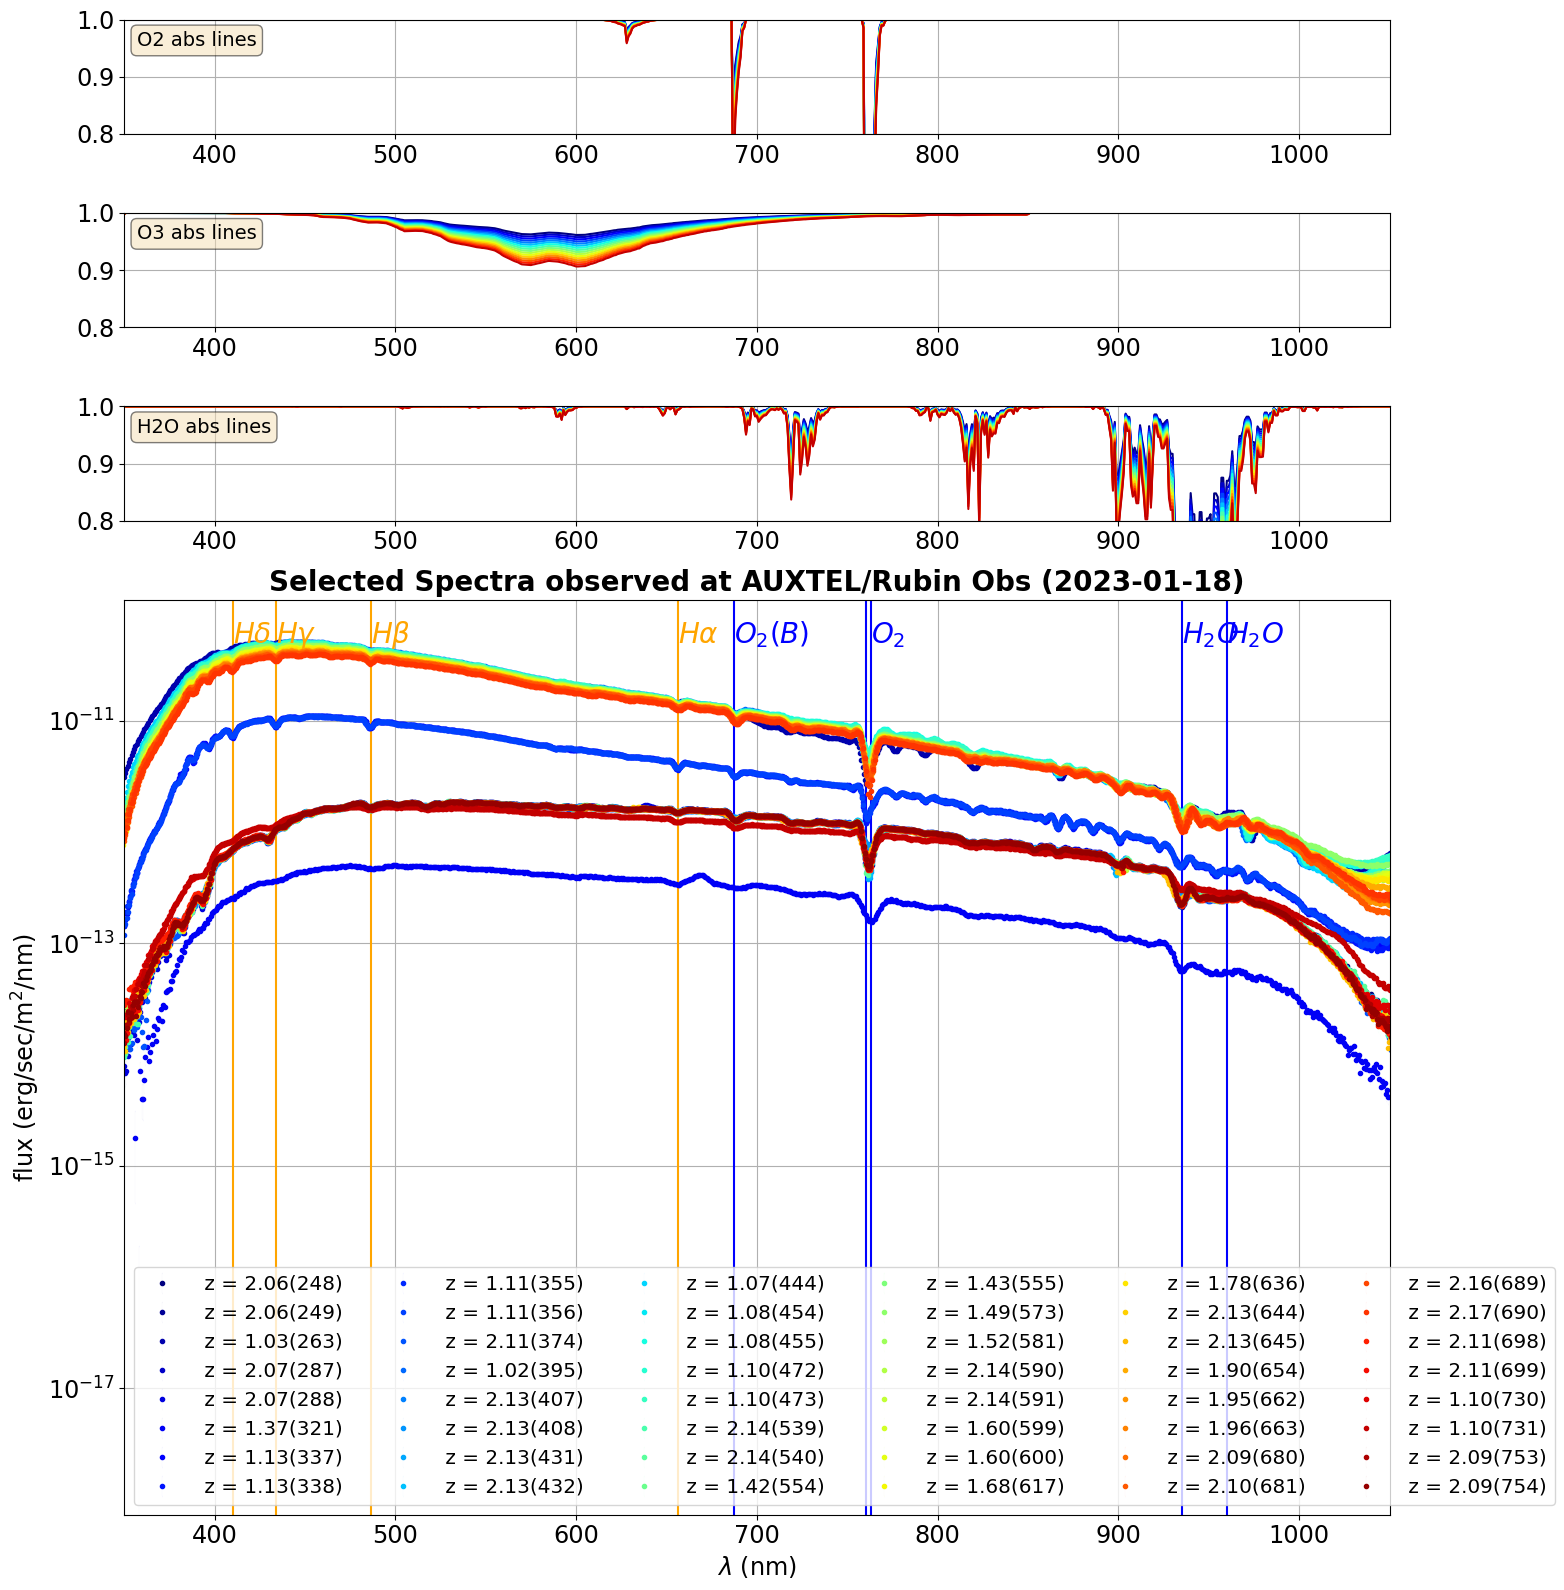

In [72]:
figsize=(16,16)

NOBS = o2.shape[1]
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig=plt.figure(figsize=figsize)
title =f"Spectra (hologram) {SITE} ({DATE})"


#gs = gridspec.GridSpec(5, 1,height_ratios=[0.5,0.5,0.5,0.5,4] ,figure=fig)
gs = gridspec.GridSpec(4, 1,height_ratios=[0.5,0.5,0.5,4] ,figure=fig)

#=========================================================== NO2    
#ax=fig.add_subplot(gs[0,0])
#for index in np.arange(NOBS):   
#    ax.plot(wlpt,no2[:,index],'-',color=all_colors[index])
#ax.set_ylim(0.8,1)
#ax.set_xlim(WLMINSEL,WLMAXSEL)
#ax.grid()
#textstr = "NO2 abs lines"
# place a text box in upper left in axes coords
#ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
#        verticalalignment='top', bbox=props)
#ax.set_title(title,fontsize=20,fontweight='bold')
#main_ax = ax



#=========================================================== O2    
#ax=fig.add_subplot(gs[0,0], sharex=main_ax)
ax=fig.add_subplot(gs[0,0])
for index in np.arange(NOBS):   
    ax.plot(wlpt,o2[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O2 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
#ax.set_title(title)
main_ax = ax

#=========================================================== Ozone
ax=fig.add_subplot(gs[1,0], sharex=main_ax)
for index in np.arange(NOBS):   
    ax.plot(wlpt,o3[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.set_xlim(WLMINSEL,WLMAXSEL)
ax.grid()
textstr = "O3 abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


#=========================================================== H2O
ax=fig.add_subplot(gs[2,0], sharex=main_ax)

for index in np.arange(NOBS):   
    ax.plot(wlpt,h2o[:,index],'-',color=all_colors[index])
ax.set_ylim(0.8,1)
ax.grid()
textstr = "H2O abs lines"
# place a text box in upper left in axes coords
ax.text(0.01, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


#================================================= spectra
ax=fig.add_subplot(gs[3,0], sharex=main_ax)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)
all_numbers = infos['number'].values



for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    the_number = all_numbers[ifile]
    label_airmass = f" z = {airmassvalue:.2f}({the_number})"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
#ax.plot(sed_w,sed_f,'k-')
#ax.set_xlim(350,1000)
#ax.set_ylim(1e-14,1e-10)
#ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
ax.legend(loc="lower left",ncol=6)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/2)

plt.tight_layout()


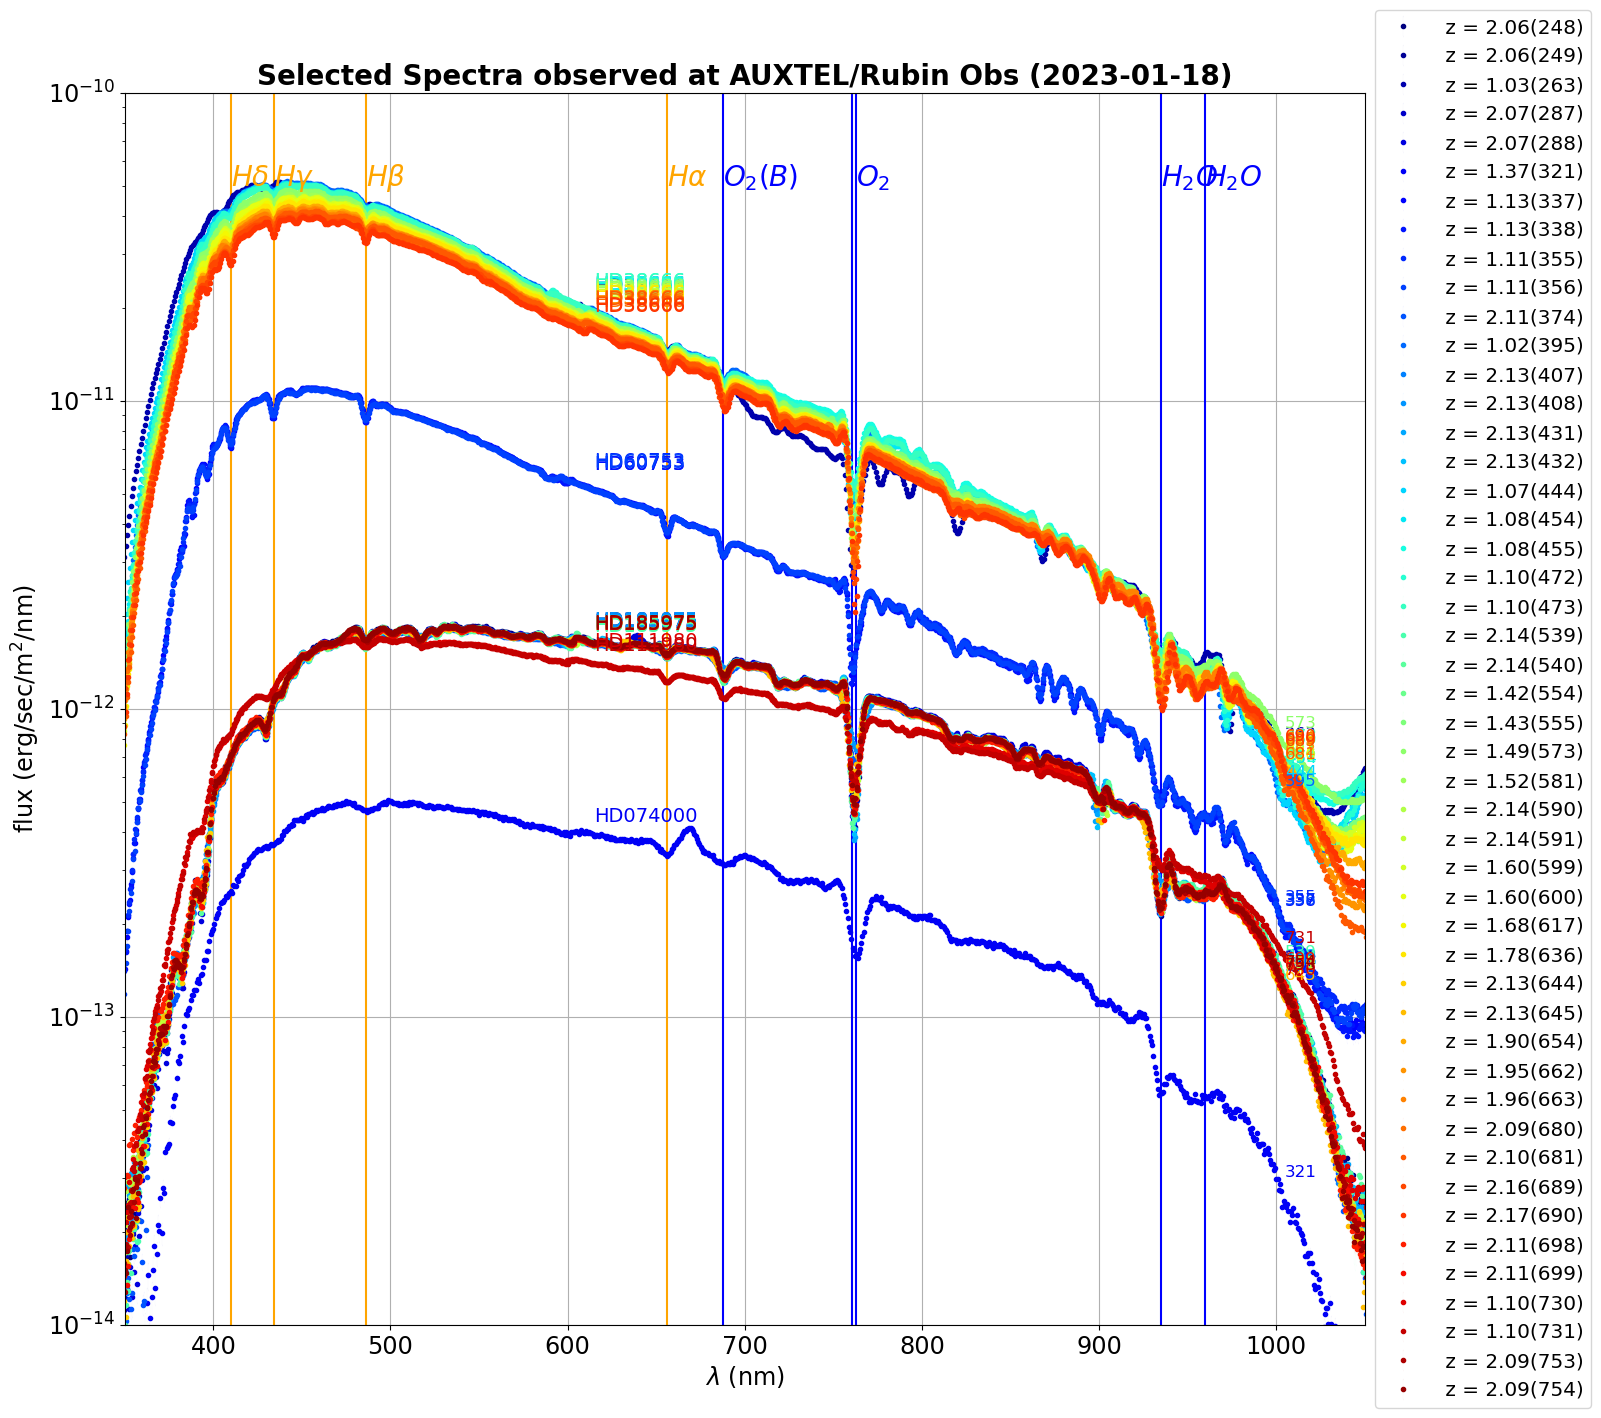

In [89]:
fig=plt.figure(figsize=(16,16))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    the_number = all_numbers[ifile]
    label_airmass = f" z = {airmassvalue:.2f}({the_number})"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)

    f_flux = interpolate.interp1d(the_df["all_lambdas"].values,the_df['all_fluxes'].values,bounds_error=False,fill_value=0)
    x1=1000.
    y1=f_flux(x1)
    s1=str(the_number)
    x2=600
    y2=f_flux(x2)
    s2=infos.iloc[ifile]["object"]
    ax.text(x1+5, y1, s1, color=all_colors[ifile],fontsize=12)
    ax.text(x2+15, y2*1.1, s2, color=all_colors[ifile],fontsize=14)
    
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Selected Spectra observed at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
#ax.plot(sed_w,sed_f,'k-')
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
#ax.legend(loc="lower left",ncol=5)
#ax.legend(bbox_to_anchor=(1.02, 0.5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/2)


In [74]:
correction_area = 1.06/1.13

In [75]:
#sed_predicted_f = f_sed(WL) * f_thr(WL) * f_atm(WL) 
#sed_predicted_m = -2.5*np.log10(sed_predicted_f) 

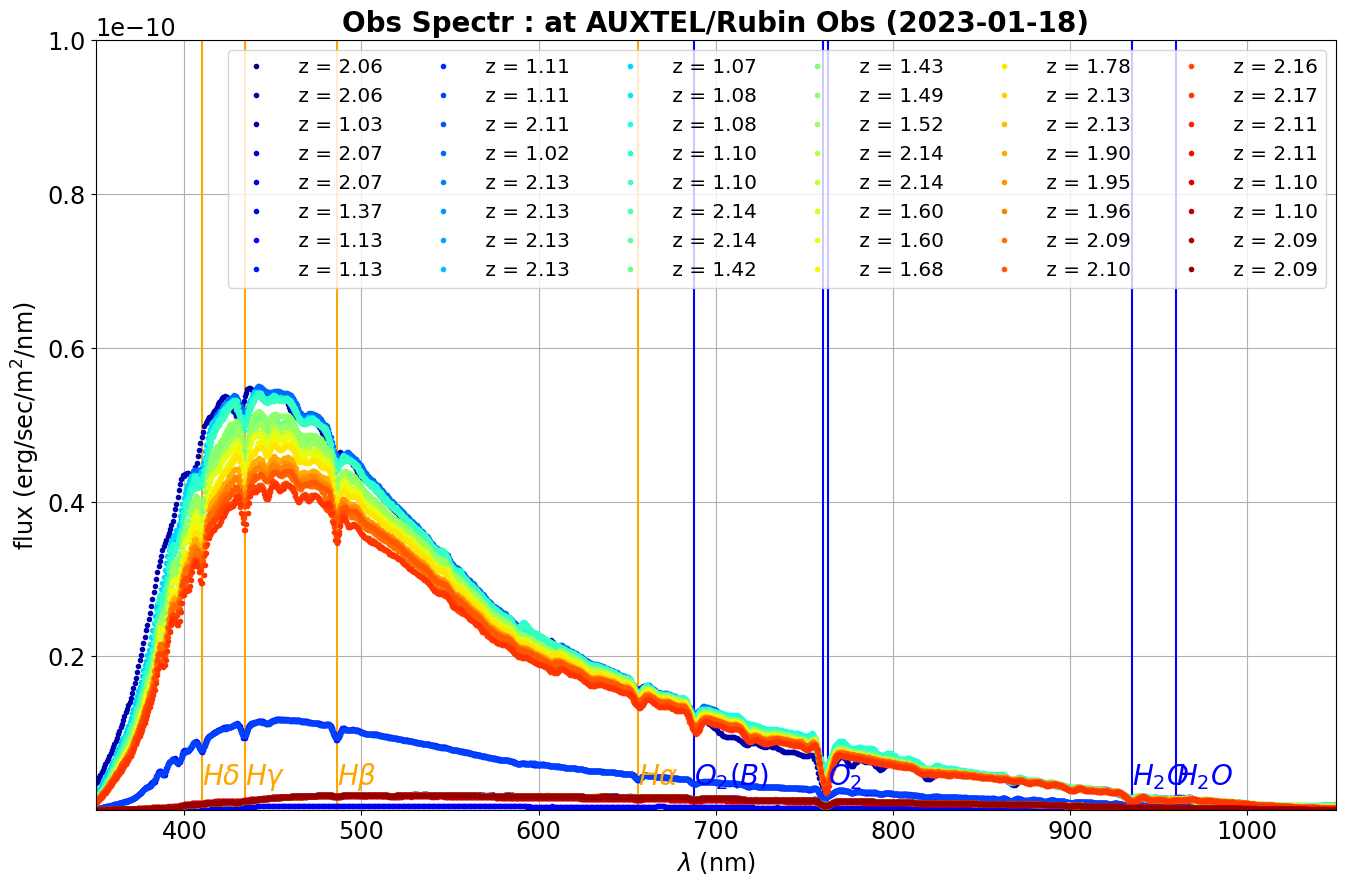

In [79]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes']/correction_area,yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Obs Spectr : at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
#ax.plot(sed_w,sed_f,'k-',label="SED")
#ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
#ax.set_yscale("log")
ax.legend(loc="upper right",ncol=6)


# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/30)


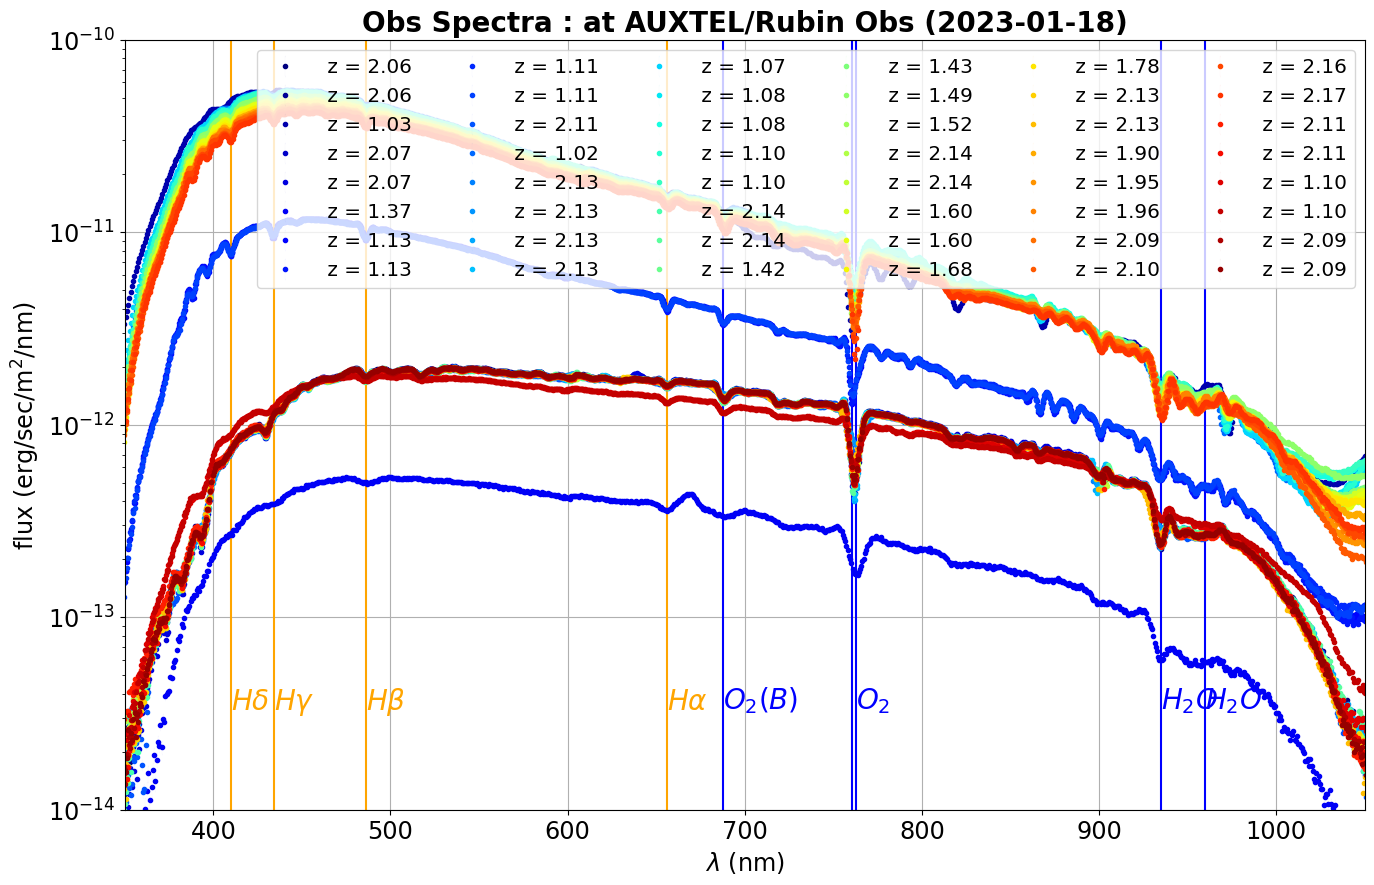

In [78]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
for ifile in np.arange(NBSPECTRA):
    the_df=all_spectra[ifile]
    
    airmassvalue = infos.iloc[ifile]["airmass"]
    label_airmass = f" z = {airmassvalue:.2f}"

    #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
    ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes']/correction_area,yerr=the_df["all_fluxes_err"], fmt = '.', color=all_colors[ifile],capsize = 0.01, ecolor=all_colors[ifile], elinewidth = .01,label=label_airmass)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Obs Spectra : at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
#ax.plot(sed_w,sed_f,'k-',label="SED")
#ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)
ax.set_yscale("log")
ax.legend(loc="upper right",ncol=6)

# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/3000)

# Filtering a line

In [ ]:
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(111)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Pred spectr (tot throu+ atm z=1.2) : {target} at {SITE} ({DATE})"
ax.set_title(title,fontsize=20,fontweight='bold')
ax.plot(sed_w,sed_f,'k-',label="SED")
ax.plot(WL,sed_predicted_f,color='darkviolet',lw=4,label = "predicted flux")
ax.set_xlim( WLMINSEL  , WLMAXSEL  )
ax.set_ylim(FLUXLIMMIN,FLUXLIMMAX)

# filtered flux
span = 3
sed_predicted_f_filtered = smooth_data_np_convolve(sed_predicted_f, span)
ax.plot(WL,sed_predicted_f_filtered/2,"-.",color='darkviolet',lw=4,label = "predicted flux filtered/2")


ax.set_yscale("log")
ax.legend(loc="upper right")


# draw abs lines
plotlines(ax,ypos=FLUXLIMMAX/2000)